In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [2]:
from statiskit import (linalg,
                       core,
                       pgm)

In [3]:
import math
import os

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R
library(glasso)

In [6]:
if not 'K' in os.environ:
    os.environ['K'] = str(10)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
data = core.read_csv('data.csv')

In [7]:
if not 'LASSO_PATH' in os.environ:
    os.environ['LASSO_PATH'] = "linear"
LASSO_PATH = os.environ.get('LASSO_PATH')
if not 'PENALTIES' in os.environ:
    os.environ['PENALTIES'] = str(K)
PENALTIES = int(os.environ.get('PENALTIES'))

In [8]:
import itertools
import numpy
import math
S = data.covariance
for u in range(K):
    S[u, u] = float("nan")
    for v in range(u):
        S[u, v] = math.fabs(S[u, v])
        S[v, u] = S[u, v]
rhos = core.from_list(list(itertools.chain(*S.to_list())))
if LASSO_PATH == 'linear':
    rhos = numpy.linspace(rhos.min.value, rhos.max.value, PENALTIES).tolist()
elif LASSO_PATH == 'empirical':
    freq = core.frequency_estimation(data=rhos)
    rhos = [freq.estimated.quantile(rho) for rho in numpy.linspace(0., 1., PENALTIES)]
else:
    raise ValueError("'LASSO' environment variable")

In [9]:
%R data = read.csv('data.csv', header = F, sep="") 
%R -n S = cov(data)

In [10]:
graphs = []
for rho in rhos:
    %R -i rho
    theta = %R glasso(S, rho=rho)$wi
    graphs.append(pgm.UndirectedGraph(linalg.Matrix(theta)))
graphs = sorted(graphs, key = lambda graph: graph.nb_edges)
graphs = [graphs[0]] + [graphs[index] for index in range(1, len(graphs)) if not graphs[index - 1].nb_edges == graphs[index].nb_edges]

In [11]:
logLs = []
for graph in graphs:
    passed = False
    for algo in ['sGA', 'GA', 'NR']:
        try:
            mle = pgm.graphical_gaussian_estimation(algo=algo,
                                                    data=data,
                                                    graph=graph)
            logLs.append(2 *  mle.estimated.loglikelihood(data))
        except:
            pass
        else:
            passed = True
            break
    if not passed:
        logLs.append(float("nan"))
graphs, logLs = zip(*[(graph, logL) for graph, logL in zip(graphs, logLs) if not math.isnan(logL)])

In [12]:
dimensions = [graph.nb_edges for graph in graphs]
total = data.total
BICs = [logL - 2 * dimension * math.log(total) for logL, dimension in zip(logLs, dimensions)]
BIC = BICs.index(max(BICs))
AICs = [logL - 2 * dimension for logL, dimension in zip(logLs, dimensions)]
AIC = AICs.index(max(AICs))
SHs = core.SlopeHeuristic(dimensions, logLs)
SH = SHs.selector(SHs)

<IPython.core.display.Javascript object>


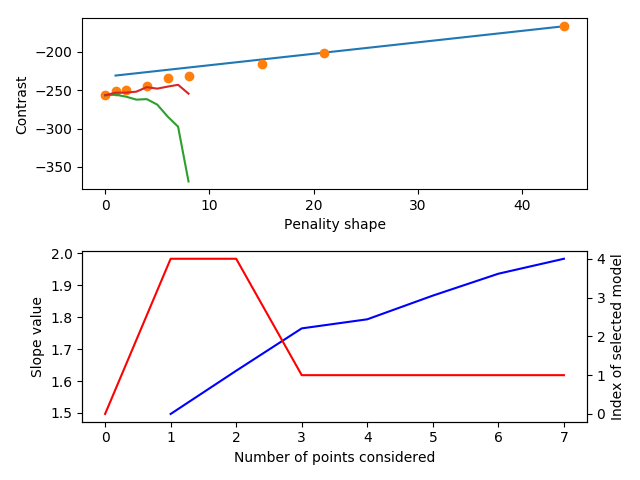

In [13]:
fig = pyplot.figure()
axes0, axes1 = SHs.plot()
axes0.plot(BICs)
axes0.plot(AICs)
pyplot.tight_layout()

<IPython.core.display.Javascript object>


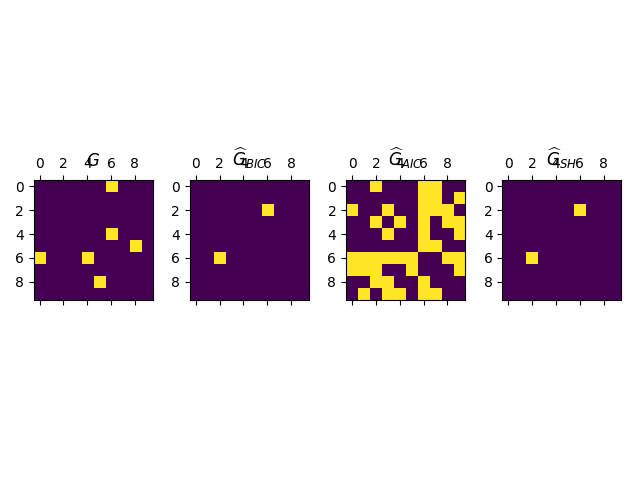

In [14]:
fig = pyplot.figure()
truth = pgm.read_gml('graph.gml')
axes = truth.to_matrix().plot(axes = fig.add_subplot(141))
axes.set_title('$G$')
index = 2
for criterion, graph in zip(['BIC', 'AIC', 'SH'], [BIC, AIC, SH]):
    axes = graphs[graph].to_matrix().plot(axes = fig.add_subplot(1, 4, index))
    axes.set_title('$\widehat{G}_{' + criterion + '}$')
    index += 1
pyplot.tight_layout()

In [15]:
def TP(truth, predicted):
    tp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and predicted.has_edge(u, v):
                tp += 1
    return tp

def TN(truth, predicted):
    tn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and not predicted.has_edge(u, v):
                tn += 1
    return tn

def FP(truth, predicted):
    fp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and not predicted.has_edge(u, v):
                fp += 1
    return fp

def FN(truth, predicted):
    fn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and predicted.has_edge(u, v):
                fn += 1
    return fn

In [16]:
import hashlib
from datetime import datetime
identifier = hashlib.md5(str(datetime.today())).hexdigest()
if not os.path.exists('paths.csv'):
    with open('paths.csv', 'w') as filehandler:
        filehandler.write('identifier,dimension,path,TP,TN,FP,FN\n')
with open('paths.csv', 'a') as filehandler:
    for graph in graphs:
        tp, tn, fp, fn = TP(truth, graph), TN(truth, graph), FP(truth, graph), FN(truth, graph)
        filehandler.write(','.join([identifier, str(K), str(LASSO_PATH), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [17]:
if not os.path.exists('paths.csv'):
    with open('criteria.csv', 'w') as filehandler:
        filehandler.write('identifier,dimension,criterion,TP,TN,FP,FN\n')
with open('criteria.csv', 'a') as filehandler:
    for criterion, graph in zip(['BIC', 'AIC', 'SH'], [BIC, AIC, SH]):
        tp, tn, fp, fn = TP(truth, graphs[graph]), TN(truth, graphs[graph]), FP(truth, graphs[graph]), FN(truth, graphs[graph])
        filehandler.write(','.join([identifier, str(K), str(criterion), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [18]:
os.remove('graph.gml')
os.remove('data.csv')